In [1]:
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from scipy.stats import linregress, gmean, pearsonr
from sklearn.metrics import r2_score
from tqdm import tqdm
from Bio import SeqIO
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from os import path
from seq_util import *

In [2]:
# Read the NOSC values for bac120 as a wide-form matrix
bac120_nosc_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_vals_wide.csv', index_col=0)

# Trim the ".1" from the end of the accession numbers so they match other GTDB data
trimmed_ids = [x.split('.')[0] for x in bac120_nosc_df.index.tolist()]
bac120_nosc_df['trimmed_accession'] = trimmed_ids

# Reset the index to the trimmed accession number
bac120_nosc_df = bac120_nosc_df.reset_index().set_index('trimmed_accession')
bac120_nosc_df

,accession,PF00380.20,PF00410.20,PF00466.21,PF01025.20,PF02576.18,PF03726.15,TIGR00006,TIGR00019,TIGR00020,...,TIGR02432,TIGR02729,TIGR03263,TIGR03594,TIGR03625,TIGR03632,TIGR03654,TIGR03723,TIGR03725,TIGR03953
trimmed_accession,,,,,,,,,,,,,,,,,,,,,
GB_GCA_000007325,GB_GCA_000007325.1,-0.148160,-0.224515,-0.271998,-0.122832,-0.222500,-0.195491,-0.189573,-0.152311,-0.116115,...,-0.239489,-0.215168,-0.138229,-0.214850,-0.219437,-0.161122,-0.178828,-0.207375,-0.232777,-0.213205
GB_GCA_000008885,GB_GCA_000008885.1,-0.225820,-0.247991,-0.235449,-0.223839,NaN,-0.212832,-0.275949,-0.212414,-0.160727,...,-0.280723,-0.219518,-0.278769,-0.307224,-0.212944,-0.103641,-0.312473,-0.254505,NaN,-0.265804
GB_GCA_000009845,GB_GCA_000009845.1,-0.210141,-0.304301,-0.323290,-0.130158,NaN,NaN,-0.202842,-0.193418,-0.160336,...,-0.243972,-0.205122,-0.180596,-0.214562,-0.172616,-0.165642,-0.229449,-0.217595,-0.288547,-0.173903
GB_GCA_000010085,GB_GCA_000010085.1,-0.097661,-0.237436,-0.161992,-0.060054,-0.167924,-0.131780,-0.111915,-0.063734,-0.064409,...,-0.078462,-0.093497,-0.132986,-0.143900,-0.152612,-0.093533,-0.164809,-0.124286,-0.153650,-0.178778
GB_GCA_000010565,GB_GCA_000010565.1,-0.187030,-0.251788,-0.224343,-0.079801,-0.200000,-0.177482,-0.149577,-0.113914,-0.096177,...,-0.179268,-0.101351,-0.181850,-0.177694,-0.190099,-0.100300,-0.222171,-0.170978,-0.203634,-0.148263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RS_GCF_907165215,RS_GCF_907165215.1,-0.168351,-0.201494,-0.224994,0.007326,-0.164994,-0.175330,-0.101722,-0.107393,-0.080776,...,-0.094517,-0.119690,-0.146439,-0.160860,-0.166670,-0.079130,-0.202686,-0.165731,-0.105502,-0.180360
RS_GCF_910593725,RS_GCF_910593725.1,-0.135314,-0.215554,-0.229864,-0.090785,-0.128396,-0.183764,-0.143342,-0.056712,-0.057451,...,-0.149315,-0.126020,-0.135354,-0.156069,-0.162119,-0.094318,-0.218050,-0.177884,-0.155941,-0.194961
RS_GCF_910593785,RS_GCF_910593785.1,-0.127126,-0.160112,-0.166364,-0.010832,NaN,-0.149092,-0.114223,-0.054536,-0.100068,...,-0.014610,-0.111930,-0.085451,-0.119093,-0.104254,-0.086850,-0.194778,-0.170642,-0.117131,-0.125924


In [3]:
# Read the annotated bac120 metadata
bac120_meta_df = pd.read_csv('../data/gtdb/r207/bac120_msa_marker_info_r207_annot.csv',
                             index_col=0)

# Read the genome average NOSC values for representative genomes
reps_genome_nosc_df = pd.read_csv('../data/gtdb/r207/genome_average_nosc.csv', index_col=0)
reps_genome_nosc_df.head()

,genome_avg_NOSC
genome_accession,
RS_GCF_000971475,-0.159401
RS_GCF_003693265,-0.119059
GB_GCA_018969935,-0.152630
GB_GCA_016790845,-0.158100
GB_GCA_900321855,-0.175164


In [4]:
# Merge the genome average values into the bac120 nosc dataframe
bac120_nosc_df = bac120_nosc_df.merge(reps_genome_nosc_df, left_index=True, right_index=True)
bac120_nosc_df.head()

,accession,PF00380.20,PF00410.20,PF00466.21,PF01025.20,PF02576.18,PF03726.15,TIGR00006,TIGR00019,TIGR00020,...,TIGR02729,TIGR03263,TIGR03594,TIGR03625,TIGR03632,TIGR03654,TIGR03723,TIGR03725,TIGR03953,genome_avg_NOSC
GB_GCA_000007325,GB_GCA_000007325.1,-0.148160,-0.224515,-0.271998,-0.122832,-0.222500,-0.195491,-0.189573,-0.152311,-0.116115,...,-0.215168,-0.138229,-0.214850,-0.219437,-0.161122,-0.178828,-0.207375,-0.232777,-0.213205,-0.223900
GB_GCA_000008885,GB_GCA_000008885.1,-0.225820,-0.247991,-0.235449,-0.223839,NaN,-0.212832,-0.275949,-0.212414,-0.160727,...,-0.219518,-0.278769,-0.307224,-0.212944,-0.103641,-0.312473,-0.254505,NaN,-0.265804,-0.258189
GB_GCA_000009845,GB_GCA_000009845.1,-0.210141,-0.304301,-0.323290,-0.130158,NaN,NaN,-0.202842,-0.193418,-0.160336,...,-0.205122,-0.180596,-0.214562,-0.172616,-0.165642,-0.229449,-0.217595,-0.288547,-0.173903,-0.225228
GB_GCA_000010085,GB_GCA_000010085.1,-0.097661,-0.237436,-0.161992,-0.060054,-0.167924,-0.131780,-0.111915,-0.063734,-0.064409,...,-0.093497,-0.132986,-0.143900,-0.152612,-0.093533,-0.164809,-0.124286,-0.153650,-0.178778,-0.147696
GB_GCA_000010565,GB_GCA_000010565.1,-0.187030,-0.251788,-0.224343,-0.079801,-0.200000,-0.177482,-0.149577,-0.113914,-0.096177,...,-0.101351,-0.181850,-0.177694,-0.190099,-0.100300,-0.222171,-0.170978,-0.203634,-0.148263,-0.179736


In [5]:
# Load metadata about all the genomes
gtdb_genome_metadata = pd.read_csv('../data/gtdb/r207/bac120_metadata_r207.tar.gz',
                                   compression='gzip', sep='\t')

# Extract the phylogeny from the metadata
gtdb_phylo = gtdb_genome_metadata.gtdb_taxonomy.str.split(';', expand=True)
gtdb_phylo.columns = ['gtdb_domain', 'gtdb_phylum', 'gtdb_class', 'gtdb_order',
                      'gtdb_family', 'gtdb_genus', 'gtdb_species']
# Strip the underscores from the names
gtdb_phylo = gtdb_phylo.applymap(lambda x: x.split('__')[1] if type(x) == str else x)
gtdb_genome_metadata = pd.concat([gtdb_genome_metadata, gtdb_phylo], axis=1)

# Rename the first column to "genome_accession" -- for some reason defaults to the filename
# Also drop the rows with no accession number
gtdb_genome_metadata = gtdb_genome_metadata.rename(
    columns={gtdb_genome_metadata.columns[0]: 'genome_accession'}).dropna(
        axis=0, subset=['genome_accession']).set_index('genome_accession')

# For some reason the accession numbers have ".1" appended to them here 
# but not in the files defining the bac120 marker genes
trimmed_ids = [x.split('.')[0] for x in gtdb_genome_metadata.index.tolist()]
gtdb_genome_metadata['trimmed_accession'] = trimmed_ids
gtdb_genome_metadata['ncbi_taxid_int'] = gtdb_genome_metadata.ncbi_taxid.astype(int)
gtdb_genome_metadata = gtdb_genome_metadata.reset_index().set_index('trimmed_accession')

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_4852/3351634197.py:2: DtypeWarning: Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  gtdb_genome_metadata = pd.read_csv('../data/gtdb/r207/bac120_metadata_r207.tar.gz',


In [6]:
# Count up the categories among the bac120
cat_counts = bac120_meta_df.COG.value_counts()

# Add descriptive annotations
cog_df = pd.read_csv('../data/COG-fun-20.csv', index_col=0)
descs = cog_df.loc[cat_counts.index].description
cat_counts = pd.DataFrame(
    dict(count=cat_counts, description=descs))
cat_counts

,count,description
J,70,"Translation, ribosomal structure and biogenesis"
L,18,"Replication, recombination and repair"
K,6,Transcription
U,6,"Intracellular trafficking, secretion, and vesi..."
F,5,Nucleotide transport and metabolism
O,5,"Posttranslational modification, protein turnov..."
H,3,Coenzyme transport and metabolism
M,3,Cell wall/membrane/envelope biogenesis
C,2,Energy production and conversion
D,1,"Cell cycle control, cell division, chromosome ..."


In [49]:
pairwise_cols = bac120_nosc_df.columns[1:-1]
mat = bac120_nosc_df[pairwise_cols].values

# Need to flatten the matrix to permute rows and cols
# correlations will not change if we only shuffle one axis
permuted = np.random.permutation(mat.flatten()).reshape(mat.shape)
permuted_df = pd.DataFrame(permuted, columns=pairwise_cols)
pingouin_corr = pg.pairwise_corr(permuted_df, method='pearson')

<AxesSubplot: xlabel='r', ylabel='Count'>

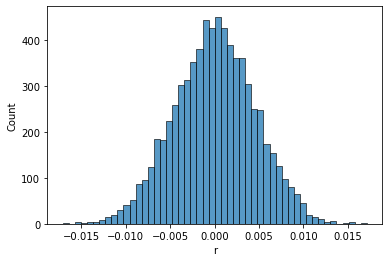

In [51]:
# Permutation totally erases the correlation structure
sns.histplot(pingouin_corr.r, bins=50)

In [7]:
# last column is genome_avg_NOSC -- 
# calculate the pairwise correlations of columns except GC
pairwise_cols = bac120_nosc_df.columns[:-1]
nosc_corr = pg.pairwise_corr(
    bac120_nosc_df, columns=pairwise_cols,
    padjust='fdr_bh')

# Now calculate the partial correlations, controlling for genome_avg_NOSC
nosc_corr_controlled = pg.pairwise_corr(
    bac120_nosc_df, columns=pairwise_cols, covar='genome_avg_NOSC',
    padjust='fdr_bh')

/opt/miniconda3/lib/python3.8/site-packages/pingouin/pairwise.py:1429: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  stats = stats[~stats[["X", "Y"]].isin(covar).any(1)]


In [8]:
f = lambda row: ','.join(sorted(row))
def _save_corr_df(corr_df, fname):
    # Add descriptions of the two columns
    corr_df['X_desc'] = bac120_meta_df.loc[corr_df.X].Description.values
    corr_df['Y_desc'] = bac120_meta_df.loc[corr_df.Y].Description.values

    # Add COG categories of the two cols
    corr_df['X_COG'] = bac120_meta_df.loc[corr_df.X].COG.values
    corr_df['Y_COG'] = bac120_meta_df.loc[corr_df.Y].COG.values

    # Order-independent COG-pair by sorting the high-level COG-categories
    
    corr_df['COG_pair'] = list(map(f, corr_df['X_COG,Y_COG'.split(',')].values))
    
    # Save
    corr_df.to_csv(fname, index=False)

    
my_fname = '../data/gtdb/r207/bac120_nosc_corr.csv'
_save_corr_df(nosc_corr, my_fname)

my_fname = '../data/gtdb/r207/bac120_nosc_corr_controlled_for_genome_nosc.csv'
_save_corr_df(nosc_corr_controlled, my_fname)

In [38]:
nosc_corr.sort_values('r', ascending=False).head(5)

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,BF10,power,X_desc,Y_desc,X_COG,Y_COG,COG_pair
3487,TIGR00344,TIGR00392,pearson,two-sided,51309,0.817759,"[0.81, 0.82]",0.0,0.0,fdr_bh,inf,1.0,alanine--tRNA ligase,isoleucine--tRNA ligase,J,J,"J,J"
3747,TIGR00392,TIGR00456,pearson,two-sided,50441,0.813436,"[0.81, 0.82]",0.0,0.0,fdr_bh,inf,1.0,isoleucine--tRNA ligase,arginine--tRNA ligase,J,J,"J,J"
3229,TIGR00194,TIGR00392,pearson,two-sided,50982,0.811021,"[0.81, 0.81]",0.0,0.0,fdr_bh,inf,1.0,excinuclease ABC subunit C,isoleucine--tRNA ligase,L,J,"J,L"
3252,TIGR00194,TIGR00634,pearson,two-sided,47523,0.810044,"[0.81, 0.81]",0.0,0.0,fdr_bh,inf,1.0,excinuclease ABC subunit C,DNA repair protein RecN,L,L,"L,L"
5518,TIGR00643,TIGR01391,pearson,two-sided,48403,0.800016,"[0.8, 0.8]",0.0,0.0,fdr_bh,inf,1.0,ATP-dependent DNA helicase RecG,DNA primase,L,L,"L,L"


count    7140.000000
mean        0.494746
std         0.133045
min        -0.137975
25%         0.406258
50%         0.503048
75%         0.591934
max         0.817759
Name: r, dtype: float64
count    5915.000000
mean        0.488219
std         0.131468
min        -0.085737
25%         0.397447
50%         0.492745
75%         0.585979
max         0.817759
Name: r, dtype: float64


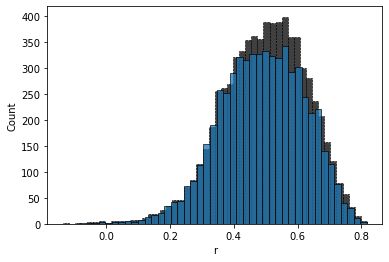

In [37]:

cog_pair_counts = nosc_corr.COG_pair.value_counts()


#complementary=True)
#mask = nosc_corr.COG_pair == 'J,J'
#sns.ecdfplot(data=nosc_corr[mask], x='r', color='red')

In [9]:
nosc_corr_controlled.sort_values('r', ascending=False).head(5)

,X,Y,method,covar,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,X_desc,Y_desc,X_COG,Y_COG,COG_pair
6992,TIGR02013,TIGR02386,pearson,['genome_avg_NOSC'],two-sided,48253,0.515868,"[0.51, 0.52]",0.0,0.0,fdr_bh,"DNA-directed RNA polymerase, beta subunit","DNA-directed RNA polymerase, beta' subunit",K,K,"K,K"
3739,TIGR00392,TIGR00414,pearson,['genome_avg_NOSC'],two-sided,50744,0.500300,"[0.49, 0.51]",0.0,0.0,fdr_bh,isoleucine--tRNA ligase,serine--tRNA ligase,J,J,"J,J"
6399,TIGR01059,TIGR01063,pearson,['genome_avg_NOSC'],two-sided,47364,0.492156,"[0.49, 0.5]",0.0,0.0,fdr_bh,"DNA gyrase, B subunit","DNA gyrase, A subunit",L,L,"L,L"
3487,TIGR00344,TIGR00392,pearson,['genome_avg_NOSC'],two-sided,51309,0.488678,"[0.48, 0.5]",0.0,0.0,fdr_bh,alanine--tRNA ligase,isoleucine--tRNA ligase,J,J,"J,J"
3747,TIGR00392,TIGR00456,pearson,['genome_avg_NOSC'],two-sided,50441,0.485915,"[0.48, 0.49]",0.0,0.0,fdr_bh,isoleucine--tRNA ligase,arginine--tRNA ligase,J,J,"J,J"


In [12]:
# Madin et al. 2020 compendium of microbial physiology traits contains growth rate information
madin_df = pd.read_csv('../data/physiology/madin_et_al/condensed_species_GTDB[NCBI_fill]_16102020.csv')
# Calculate the growth rate in /hr from the doubling time
madin_df['growth_rate_hr'] = np.log(2)/madin_df['doubling_h']

0.11003769216720316


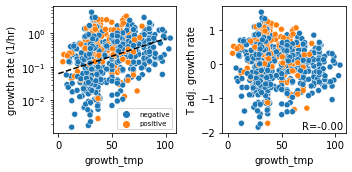

In [13]:
# Data from Madin et al. 2020 doesn't include T-normalized growth rate analysis 
# from Westoby et al. 2021, so we'll do that here. Basic idea is to treat the 
# species-specific component of the growth rate as the deviation from the trend
# of growth rate with growth temperature. 

# In this cell we just recreate the analysis of Westoby 2021 and save it. 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 2.5), sharex=True)

plt.sca(axs[0])
plt.yscale('log')
sns.scatterplot(data=madin_df, x='growth_tmp', y='growth_rate_hr', hue='gram_stain')

mask = np.logical_and(madin_df['growth_tmp'] > 0, madin_df['growth_rate_hr'] > 0)
masked_madin = madin_df[mask]
res = linregress(masked_madin['growth_tmp'], np.log10(masked_madin['growth_rate_hr']))
xs = np.linspace(0, 100, 100)
fit_ys = 10**(res.intercept + res.slope * xs)
plt.plot(xs, fit_ys, color='k', linestyle='--')
plt.legend(fontsize=7)
plt.ylabel('growth rate (1/hr)')

pred_log_ys = res.intercept + res.slope * masked_madin['growth_tmp']
pred_ys = 10**(res.intercept + res.slope * masked_madin['growth_tmp'])
# Westoby report at R^2 of 0.110, which is what we get too. 
r2 = r2_score(np.log10(masked_madin['growth_rate_hr']), np.log10(pred_ys))

# Westoby calculates the residuals in log-space
residuals = np.log10(masked_madin['growth_rate_hr']) - pred_log_ys

madin_df['temp_adjusted_max_growth_rate'] = np.NAN
madin_df.loc[mask, 'temp_adjusted_max_growth_rate'] = residuals

plt.sca(axs[1])
sns.scatterplot(data=madin_df, x='growth_tmp', y='temp_adjusted_max_growth_rate', hue='gram_stain')
plt.legend().set_visible(False)

# Remaining correlation should be ~0 after de-trending.
# Presumably there is remaining phylogenetic signal here... 
masked_madin = madin_df[mask]
reg2 = linregress(masked_madin['growth_tmp'], masked_madin['temp_adjusted_max_growth_rate'])
plt.text(0.98, 0.03, 'R={0:.2f}'.format(reg2.rvalue), transform=axs[1].transAxes, ha='right')
plt.ylabel('T adj. growth rate')

print(r2)
plt.tight_layout()

In [14]:
# Merge the Madin et al. 2020 data with the GTDB metadata
merged_madin_gtdb_df = gtdb_genome_metadata.reset_index().merge(
    madin_df, left_on='ncbi_taxid_int', right_on='species_tax_id', how='inner').set_index('trimmed_accession')

In [15]:
merged_madin_gtdb_df

,genome_accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,coding_genes.stdev,optimum_tmp.stdev,optimum_ph.stdev,growth_tmp.stdev,rRNA16S_genes.stdev,tRNA_genes.stdev,data_source,ref_id,growth_rate_hr,temp_adjusted_max_growth_rate
trimmed_accession,,,,,,,,,,,,,,,,,,,,,
GB_GCA_000169995,GB_GCA_000169995.1,0.0,96.26,0.90,1066.0,g__Vibrio (UID4874),378.0,25.00,4995414.0,85.600748,...,NaN,NaN,NaN,NaN,NaN,NaN,"gold, patric","13521, 19897",NaN,NaN
GB_GCA_000209445,GB_GCA_000209445.1,1.0,98.73,0.00,278.0,o__Clostridiales (UID1226),158.0,0.00,2526470.0,88.807768,...,NaN,NaN,NaN,NaN,NaN,NaN,"gold, patric, protraits","13521, 19897, 19908",NaN,NaN
GB_GCA_000209515,GB_GCA_000209515.2,0.0,99.57,2.16,507.0,c__Gammaproteobacteria (UID4444),232.0,25.00,2656553.0,88.034564,...,NaN,NaN,NaN,NaN,NaN,NaN,"gold, microbe-directory","13521, 19891",NaN,NaN
GB_GCA_000209835,GB_GCA_000209835.1,0.0,97.94,0.32,278.0,o__Clostridiales (UID1226),158.0,0.00,3026082.0,85.347385,...,NaN,NaN,NaN,NaN,NaN,NaN,"gold, kegg, patric","13521, 17653, 19897",NaN,NaN
GB_GCA_000238815,GB_GCA_000238815.2,0.0,99.56,0.00,347.0,c__Alphaproteobacteria (UID3305),229.0,0.00,2254256.0,91.675739,...,NaN,NaN,NaN,NaN,NaN,NaN,"gold, microbe-directory, protraits","13521, 19891, 19908",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RS_GCF_900537105,RS_GCF_900537105.1,37.0,99.15,0.00,582.0,f__Rhodobacteraceae (UID3360),313.0,0.00,4721398.0,90.632872,...,NaN,NaN,NaN,NaN,NaN,NaN,"engqvist, gold","705, 13521",NaN,NaN
RS_GCF_900638635,RS_GCF_900638635.1,0.0,100.00,1.22,705.0,o__Rhizobiales (UID3480),226.0,33.33,1633588.0,81.880622,...,25.716,NaN,NaN,NaN,0.0,0.0,"bacdive-microa, engqvist, genbank, gold, jemma...","151, 705, 6849, 13521, 13693, 17527, 19891, 19...",NaN,NaN
RS_GCF_900660745,RS_GCF_900660745.1,0.0,99.33,0.00,126.0,k__Bacteria (UID2328),75.0,0.00,1725538.0,91.632888,...,NaN,NaN,NaN,NaN,NaN,NaN,"engqvist, gold, protraits, rrndb","705, 13521, 19908, 19953",NaN,NaN


In [16]:
mask = merged_madin_gtdb_df['temp_adjusted_max_growth_rate'].notnull()
# There are multiple GTDB accessions for some NCBI accessions, so we'll just take the first one
# NOTE: we are working the the GTDB representative genomes here. Perhaps we should "smear" growth 
# rates from measured organisms to their closest representative to get more data. 
# NOTE: there are a number of cases where multiple phylogenetic classes are mapped to the same NCBI taxid.
# It is usually clear which is the error (e.g. 100 are proteobacteria, but one is a firmicute). 
# Using 'first' here runs the risk of picking the wrong one. Ignoring for now. 
has_gr = merged_madin_gtdb_df[mask].reset_index().groupby('ncbi_taxid_int').first().set_index('trimmed_accession')

In [17]:
# Calculate residuals by phylogenetic class
resid_x_gtdb_class = resid_x.groupby(gtdb_genome_metadata.loc[resid_x.index].gtdb_class).describe()
resid_y_gtdb_class = resid_y.groupby(gtdb_genome_metadata.loc[resid_y.index].gtdb_class).describe()
resid_y_gtdb_class.head()

,count,mean,std,min,25%,50%,75%,max
gtdb_class,,,,,,,,
0-14-0-80-59-12,1.0,-0.029864,NaN,-0.029864,-0.029864,-0.029864,-0.029864,-0.029864
2-12-FULL-45-22,1.0,-0.003651,NaN,-0.003651,-0.003651,-0.003651,-0.003651,-0.003651
2-12-FULL-62-27,2.0,0.005683,0.007695,0.000242,0.002962,0.005683,0.008403,0.011124
32-111,4.0,-0.001679,0.013738,-0.017624,-0.010784,-0.000276,0.008828,0.011459
4484-107,2.0,-0.003874,0.022653,-0.019892,-0.011883,-0.003874,0.004135,0.012144


In [18]:
# Calculate mean max growth rate by phylogenetic class
cols = 'gtdb_class,growth_rate_hr,temp_adjusted_max_growth_rate,rRNA16S_genes,lsu_23s_count'.split(',')
mean_grs_by_class = merged_madin_gtdb_df[cols].groupby('gtdb_class').describe()
mean_grs_by_class.head()

growth_rate_hr                                          \
                             count      mean       std       min       25%   
gtdb_class                                                                   
ABY1                           0.0       NaN       NaN       NaN       NaN   
Acidimicrobiia                 0.0       NaN       NaN       NaN       NaN   
Acidobacteriae                 3.0  0.068435  0.045642  0.022360  0.045837   
Actinomycetia                842.0  0.480085  0.421599  0.002888  0.135911   
Alphaproteobacteria         1128.0  0.343712  0.143713  0.003707  0.330070   

                                                   \
                          50%       75%       max   
gtdb_class                                          
ABY1                      NaN       NaN       NaN   
Acidimicrobiia            NaN       NaN       NaN   
Acidobacteriae       0.069315  0.091473  0.113631   
Actinomycetia        0.459038  0.459038  1.920075   
Alphaproteobacteria  0.393387  0.411852  1.611970   

                    temp_adjusted_max_growth_rate            ...  \
                                            count      mean  ...   
gtdb_class                                                   ...   
ABY1                                          0.0       NaN  ...   
Acidimicrobiia                                0.0       NaN  ...   
Acidobacteriae                                3.0 -0.325191  ...   
Actinomycetia                               842.0  0.288058  ...   
Alphaproteobacteria                        1128.0  0.338323  ...   

                    rRNA16S_genes         lsu_23s_count                      \
                              75%     max         count      mean       std   
gtdb_class                                                                    
ABY1                          NaN     NaN           1.0  1.000000       NaN   
Acidimicrobiia               1.75   2.000          18.0  0.666667  0.594089   
Acidobacteriae               2.00   2.000          59.0  0.779661  0.559180   
Actinomycetia                4.20   9.000        6884.0  2.126671  1.894483   
Alphaproteobacteria          4.00  13.312        5361.0  1.480321  1.321194   

                                               
                     min  25%  50%  75%   max  
gtdb_class                                     
ABY1                 1.0  1.0  1.0  1.0   1.0  
Acidimicrobiia       0.0  0.0  1.0  1.0   2.0  
Acidobacteriae       0.0  0.0  1.0  1.0   2.0  
Actinomycetia        0.0  1.0  1.0  3.0  28.0  
Alphaproteobacteria  0.0  1.0  1.0  2.0  13.0  

[5 rows x 32 columns]

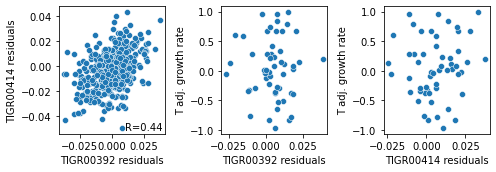

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5))

plt.sca(axs[0])
col = 'mean'
sns.scatterplot(x=resid_x_gtdb_class[col], y=resid_y_gtdb_class[col])
rval, p = pearsonr(resid_x_gtdb_class[col], resid_y_gtdb_class[col])
plt.text(0.98, 0.03, 'R={0:.2f}'.format(rval), transform=axs[0].transAxes, ha='right')
plt.xlabel('TIGR00392 residuals')
plt.ylabel('TIGR00414 residuals')

plt.sca(axs[1])
col2 = ('temp_adjusted_max_growth_rate', 'mean')
sns.scatterplot(x=resid_x_gtdb_class[col], y=mean_grs_by_class[col2])
#rval1, p1 = pearsonr(resid_x_gtdb_class[col], mean_grs_by_class[col2])
#plt.text(0.98, 0.03, 'R={0:.2f}'.format(rval1), transform=axs[1].transAxes, ha='right')
plt.xlabel('TIGR00392 residuals')
plt.ylabel('T adj. growth rate')

plt.sca(axs[2])
sns.scatterplot(x=resid_y_gtdb_class[col], y=mean_grs_by_class[col2])
#rval2, p2 = pearsonr(resid_y_gtdb_class[col], mean_grs_by_class[col2])
#plt.text(0.98, 0.03, 'R={0:.2f}'.format(rval2), transform=axs[2].transAxes, ha='right')
plt.xlabel('TIGR00414 residuals')
plt.ylabel('T adj. growth rate')


plt.tight_layout()
plt.show()

NameError: name 'resid_x_w_gr' is not defined

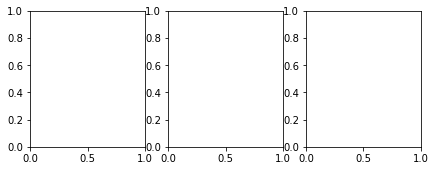

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5))

plt.sca(axs[0])
sns.scatterplot(x=resid_x_w_gr, y=resid_y_w_gr, hue=has_gr.loc[overlap_idx]['growth_rate_hr'], legend=False)
plt.xlabel('TIGR00392 residuals')
plt.ylabel('TIGR00414 residuals')

plt.sca(axs[1])
sns.scatterplot(x=resid_x_w_gr, y=has_gr.loc[overlap_idx]['growth_rate_hr'])

plt.sca(axs[2])
sns.scatterplot(x=resid_y_w_gr, y=has_gr.loc[overlap_idx]['growth_rate_hr'])

plt.tight_layout()
plt.show()

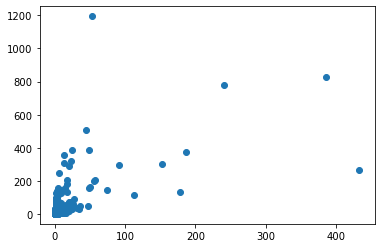

In [ ]:
plt.scatter(madin_in_gtdb.doubling_h, madin_in_gtdb.doubling_h_norm)

In [ ]:
mask = madin_df.doubling_h.notnull()
cols = 'species_tax_id,gram_stain,metabolism,doubling_h,doubling_h_norm'.split(',')
madin_df[mask][cols]

,species_tax_id,gram_stain,metabolism,doubling_h,doubling_h_norm
56,1229250,NaN,aerobic,1.00,16.000000
57,1081799,NaN,aerobic,3.96,32.122236
58,2018083,NaN,aerobic,6.21,8.366321
59,1323370,NaN,anaerobic,0.92,14.720000
60,192731,NaN,aerobic,71.08,284.320000
...,...,...,...,...,...
17294,1508420,negative,anaerobic,8.22,134.284000
17718,1715806,NaN,NaN,9.70,46.141000
18060,1884585,NaN,facultative,3.00,1.098000
18077,1891658,NaN,facultative,0.34,10.956000


In [ ]:
madin_df.columns.values

array(['species_tax_id', 'gram_stain', 'metabolism', 'pathways',
       'carbon_substrates', 'sporulation', 'motility', 'range_tmp',
       'range_salinity', 'cell_shape', 'isolation_source', 'd1_lo',
       'd1_up', 'd2_lo', 'd2_up', 'doubling_h', 'doubling_h_norm',
       'genome_size', 'gc_content', 'coding_genes', 'optimum_tmp',
       'optimum_ph', 'growth_tmp', 'rRNA16S_genes', 'tRNA_genes',
       'superkingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'species', 'gtdb_phyl_lvl', 'gram_stain.count', 'metabolism.count',
       'pathways.count', 'carbon_substrates.count', 'sporulation.count',
       'motility.count', 'range_tmp.count', 'range_salinity.count',
       'cell_shape.count', 'isolation_source.count', 'gram_stain.prop',
       'metabolism.prop', 'pathways.prop', 'carbon_substrates.prop',
       'sporulation.prop', 'motility.prop', 'range_tmp.prop',
       'range_salinity.prop', 'cell_shape.prop', 'isolation_source.prop',
       'd1_lo.count', 'd1_up.count',

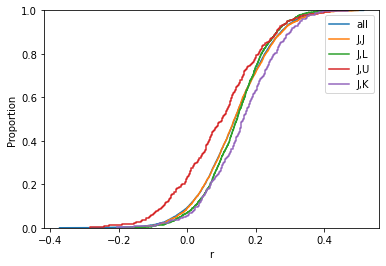

In [ ]:
pal = sns.color_palette()
pair_counts = nosc_corr_controlled.COG_pair.value_counts()

sns.ecdfplot(data=nosc_corr_controlled, x='r', label='all')

for pair in pair_counts[:4].index:
    mask = nosc_corr_controlled.COG_pair == pair
    sns.ecdfplot(data=nosc_corr_controlled[mask], x='r', label=pair)

plt.legend()
plt.show()

plotting 7140 of 7140


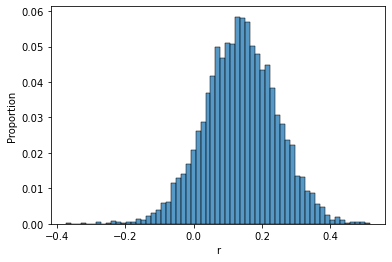

In [ ]:
print('plotting', nosc_corr_controlled.r.size, 'of', nosc_corr_controlled.r.size)
sns.histplot(data=nosc_corr_controlled, x='r', stat='proportion')
plt.show()

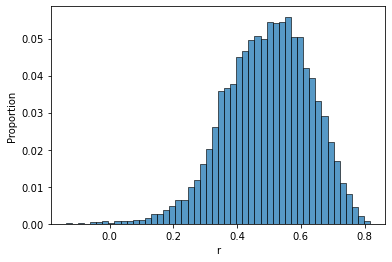

In [ ]:
sns.histplot(data=nosc_corr, x='r', stat='proportion')
plt.show()

In [ ]:
ex1 = pd.read_csv('../data/gtdb/r207/genome_nosc_examples/GB_GCA_018662075.nosc.csv', index_col=0)
ex2 = pd.read_csv('../data/gtdb/r207/genome_nosc_examples/RS_GCF_000518785.nosc.csv', index_col=0)
ex3 = pd.read_csv('../data/gtdb/r207/genome_nosc_examples/GB_GCA_019112785.nosc.csv', index_col=0)

In [ ]:
# Fit each genome to a pair of Gaussians, one for transmembrane proteins 
# and one for non-transmembrane proteins
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture


means [-0.32472396 -0.14600942]
vars [0.00373758 0.00430418]
weights [0.13618164 0.86381836]
means [-0.30094898 -0.12870107]
vars [0.00214958 0.00227515]
weights [0.12785406 0.87214594]
means [-0.32305082 -0.15277817]
vars [0.00251116 0.00273827]
weights [0.11970583 0.88029417]


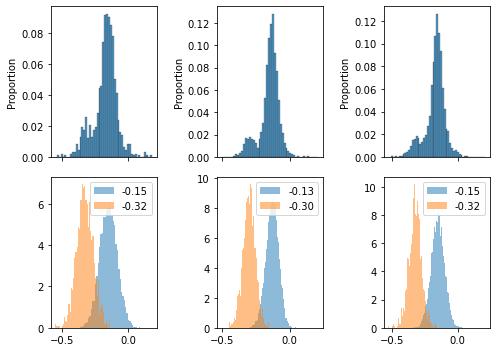

In [ ]:
fig, axs = plt.subplots(figsize=(7, 5), ncols=3, nrows=2, sharex='col')

for i, my_df in enumerate([ex1, ex2, ex3]):
    plt.sca(axs[0,i])
    gmm = BayesianGaussianMixture(n_components=2)
    vals = my_df.NOSC.values.reshape(-1, 1)
    gmm.fit(vals)

    xs, labels = gmm.sample(10000)

    component_means = gmm.means_.flatten()
    idxs = np.argsort(component_means)
    component_means = component_means[idxs]
    component_vars = gmm.covariances_.flatten()[idxs]
    component_weights = gmm.weights_.flatten()[idxs]
    print('means', component_means)
    print('vars', component_vars)
    print('weights', component_weights)
    sns.histplot(data=my_df, x='NOSC', stat='proportion', bins=50)

    plt.sca(axs[1,i])
    plt.hist(xs[labels==0], bins=50, density=True, alpha=0.5,
             label='{0:.2f}'.format(gmm.means_[0][0]))
    plt.hist(xs[labels==1], bins=50, density=True, alpha=0.5,
             label='{0:.2f}'.format(gmm.means_[1][0]))
    plt.legend()

plt.tight_layout()
plt.savefig('../output/coding_sequences_dist_ex.png', dpi=300, facecolor='white')
plt.show()

In [ ]:
bac120_nosc_df.shape

(62291, 122)

In [ ]:
reps_genome_nosc_df.genome_avg_NOSC.notnull().sum()

62291

In [ ]:
def bootstrap_mean_ci(vals, n=1000, ci=99, subsample_size=0.9):
    """Calculate the mean and confidence interval of a set of values using bootstrapping.

    Args:
        vals (array-like): The values to calculate the mean and confidence interval of.
        n (int, optional): The number of bootstrap samples to take. Defaults to 1000.
        ci (int, optional): The confidence interval to calculate in percent units. Defaults to 99%.
        subsample_size (float, optional): The fraction of the values to use in each bootstrap sample. Defaults to 0.9.
        
    Returns:
        tuple: The mean and confidence interval of the values.
    """
    # Create an array to store the bootstrap sample means
    bootstrap_means = np.zeros(n)
    size = int(len(vals) * subsample_size)

    # Perform bootstrapping
    for i in range(n):
        # Sample with replacement from the values
        bootstrap_sample = np.random.choice(vals, size=size, replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)

    # Calculate the mean of the bootstrap sample means
    mean = np.mean(bootstrap_means)

    # Calculate the confidence interval (percentile method)
    ci_mass = (100 - ci) / 2
    confidence_interval = np.percentile(bootstrap_means, [ci_mass, 100-ci_mass])

    return mean, confidence_interval

In [ ]:
vals = nosc_corr_controlled.r.values
bootstrap_mean_ci(vals)

np.percentile(vals, [25, 75])

array([0.06793312, 0.20992836])

In [ ]:
vals = nosc_corr.r.values

bootstrap_mean_ci(vals)

np.percentile(vals, [25, 75])

array([0.40625775, 0.59193439])

In [ ]:
bac120_meta_df.COG.value_counts()
cog_df

,color,description
category,,
J,FCCCFC,"Translation, ribosomal structure and biogenesis"
A,FCDCFC,RNA processing and modification
K,FCDCEC,Transcription
L,FCDCDC,"Replication, recombination and repair"
B,FCDCCC,Chromatin structure and dynamics
D,FCFCDC,"Cell cycle control, cell division, chromosome ..."
Y,FCFCCC,Nuclear structure
V,FCFCBC,Defense mechanisms
T,FCFCAC,Signal transduction mechanisms
